In [7]:
import gdspy
import qnldraw as qd
import qnldraw.library as qlib
from qnldraw import Chip
import qnldraw.shapes as shapes
import qnldraw.paths as paths
import numpy as np
import qnldraw.junction as qj

## Basic drawing

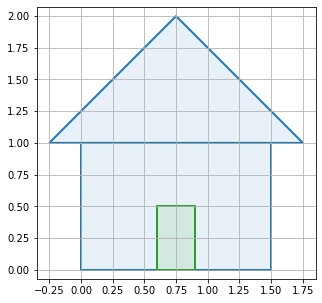

In [52]:
#Draw polygons
#A polygon consists of N points in the XY plane, and polygons are automatically closed.
poly1 = [(0, 0), (1.5, 0), (1.5, 1), (0, 1)]
poly2 = [(-0.25, 1), (1.75, 1), (0.75, 2)]

# PolygonSet takes a list of polygons and (optionally) a layer/datatype.
polyset = gdspy.PolygonSet([poly1, poly2]) #house

# Layers and datatypes are between 0 and 255 (1 byte)
polyset1 = gdspy.PolygonSet([[(0.6, 0), (0.9, 0), (0.9, 0.5), (0.6, 0.5)]], layer=2) #door

# qnldraw.plot() can be used to visualize elements
fig = qd.plot([polyset, polyset1])

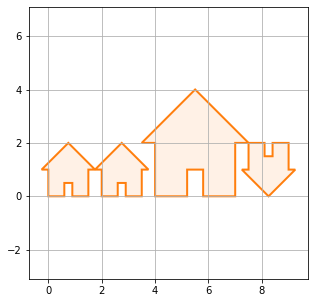

In [53]:
#Boolean
# 'or' with a single element will combine all polygons into 1
polyset = qd.boolean(polyset, None, 'or')

#'not' substract the set 2 from set 1
#assign a layer to the polygon
house = qd.boolean(polyset, polyset1, 'not', layer=1)

#Transformations: translate, rotate, mirror, scale
house_translated = gdspy.copy(house).translate(2,0)
house_scaled = gdspy.copy(house).scale(2,2).translate(4,0)
house_flipped = gdspy.copy(house).rotate(np.pi).translate(9,2)

#Plot
fig = qd.plot([house, house_translated, house_scaled, house_flipped])

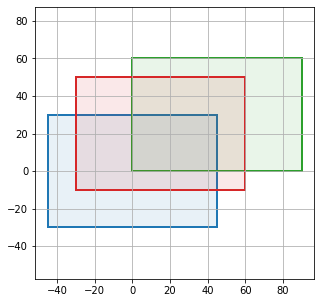

In [54]:
#Shapes
#Rectagles
# Create a rectangle with lx = 90, ly = 60 centered at the origin.
rect1 = shapes.Rectangle(90, 60)

# Create a rectangle with lx = 90, ly = 60 with the bottom left corner at the origin
rect2 = shapes.Rectangle(90, 60, 'bottom left', layer = 2)

# Create a rectangle with lx = 90, ly = 60 with the bottom left corner at (-30, -10)
rect3 = shapes.Rectangle(90, 60, (30, 10), layer = 3)

fig = qd.plot([rect1, rect2, rect3])

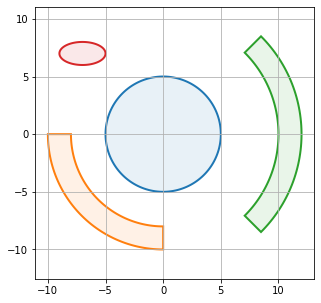

In [55]:
#Round shapes
circle = shapes.Round((0,0), 5)

# Angles are specified in deg by default.
arc1 = shapes.Round((0,0), 10, 8, 180, '-y', layer=1)

# Or radians if you insist
arc2 = shapes.Round((0,0), 12, 10, -np.pi/4, np.pi/4, layer=2, unit='rad')

# Ellipses are specified with two radii
ellipse = shapes.Round((-7, 7), (2, 1), layer=3)

fig = qd.plot([circle, arc1, arc2, ellipse])

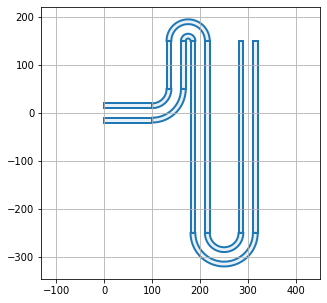

In [56]:
#CPW using Paths
#Subclass: CPW and Trace. CPW object is used to define substrate gap. Trace is used to define the metal wire

#CPW object with width = 20, gap = 10
trace = paths.CPW(20, 10)

# Draws a straight segment of length 100, the initial direction defaults to '+x' direction
trace.segment(100)

# Draws a 90deg circular turn after the straight segment with radius 50
trace.turn(50, 'l')

# Commands can be chained
trace.segment(100).turn(25, 'rr').segment(400)

trace.turn(50,'ll')
trace.segment(400)
fig =qd.plot([trace])

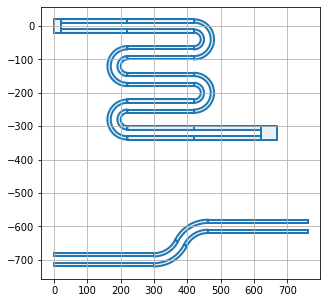

In [57]:
#CPW high level methods
# Draws an open gap with length 10, straight segment, a meandering section
# with 5 straight sections of length 200 and turns of radius 50, 
# another straight section, and finally an open gap
trace = paths.CPW(20, 10)
trace.open(20).segment(200).meander(5, 200, 40, turn=-1).segment(200).open(50)

# Draws a straight segment, shifts the y position of the CPW by 100, using
# two curves with a radius of curvature of 90 followed by another straight
# segment.
trace1 = paths.CPW(20, 10)
trace1.segment(300).shift(100, radius=90).segment(300)

fig =qd.plot([trace, trace1.translate(0,-700)])

## Components

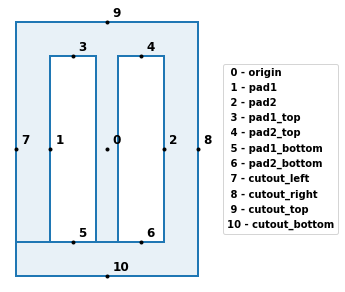

In [58]:
fig = qlib.FloatingPads.document()

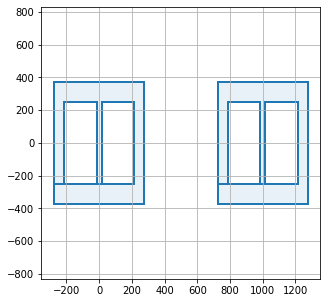

In [59]:
# Placing
# Creates a FloatingPads component
qbpads = qlib.FloatingPads(
    pads={'x': 200, 'y': 500}, 
    cutout={'x': 550, 'y': 750},
    spacing=30
)

# Places the qubit pads such that the origin in the component reference frame
# lines up with the origin in the outer reference frame
Q0 = qbpads.place()
Q1 = qbpads.place((1000,0))
fig = qd.plot([Q0,Q1])

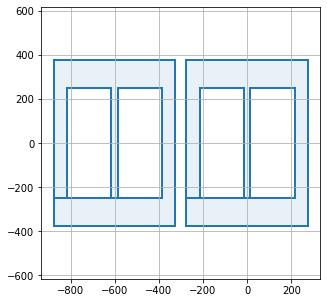

In [60]:
# Using nodes and attaching
Q2 = qbpads.attach(Q0, 'cutout_left', 'cutout_right', offset = (-50,0))
fig = qd.plot([Q0,Q2])

In [61]:
# How to get the components' parameters
print (Q0.get_params().flatkeys())

FlatKeysView(['cutout.x', 'cutout.y', 'spacing', 'pad1.x', 'pad1.y', 'pad2.x', 'pad2.y']))


In [62]:
print (Q0.get_params(['cutout.x', 'pad1.y']))

{'cutout': {'x': 550}, 'pad1': {'y': 500}}


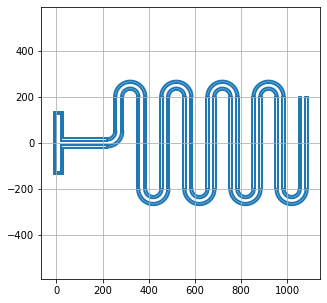

In [63]:
# Custom components
# Recommended method is to subclass Component and use draw method.
from qnldraw.library import components

class QWResonator(components.Component):
    # This tells the __init__ method to call draw() upon initialization
    __draw__ = True

    def draw(self, cpw, coupling_pad, neck, meander):
        # The pad width will be the same as the `CPW` width
        coupling_pad['pad'].update(width=cpw['width'])

        # Define a coupling pad subcomponent
        cpad = qlib.CouplingPad(
            cpw=cpw, cpw_length=neck, pad=coupling_pad['pad'], gap=cpw['gap'], name='PAD'
        ).place(node='pad', rotation=90)

        # Define the CPW trace
        trace = paths.CPW(**cpw, start=cpad.node('cpw')) \
            .turn(meander['radius'], 'l') \
            .segment(150) \
            .meander(**meander)

        # Add all elements to the component cell.
        self.add([cpad, trace])
        # Add the CPW cutout to the component.
        self.add_cutout(trace.cutout)

        nodes = {
            'end': trace.current_position(),
        }
        # draw() should return a dictionary of nodes. The origin in 
        # the compononent's reference frame is automatically added to the
        # dictionary with the key 'origin'.
        # subcomponent nodes area also automatically added
        return nodes

qw_res = QWResonator(
    cpw={'width': 20, 'gap': 10},
    ## The other parameters in coupling pad are automatically computed
    coupling_pad={'pad': {'length': 250}},
    neck=200,
    meander={
        'num_segments': 8,
        'length': 400, 
        'radius': 50,
        'turn': -1,
        'extra_turns': 'start'
    }
)

fig = qd.plot(qw_res)

In [64]:
# class antenna_symmetric(pad_length=0, pad_width=0, lead_length=0, lead_width=0, gap=0):
#     # This tells the __init__ method to call draw() upon initialization
#     __draw__ = True

#     def draw(self):
#         pad = shapes.Rectangle(pad_length, pad_width)
#         return 
# ant1 = antenna_symmetric(pad_length = 100, pad_width = 50)

## Chips

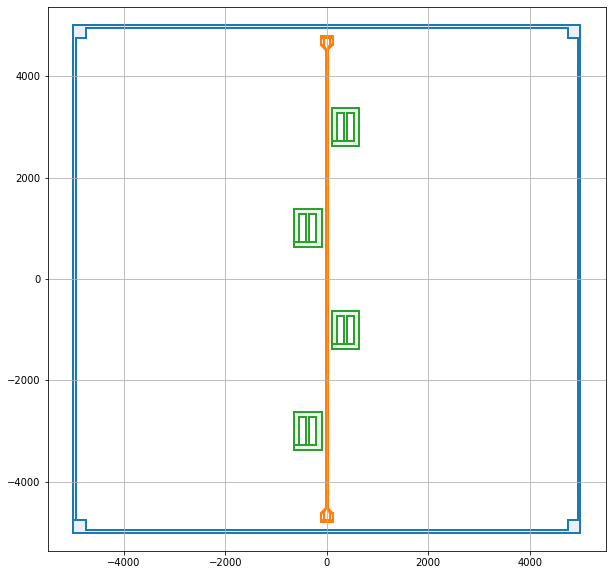

In [65]:
# Chip class helps with laying out components, handling intersections, and selectively rendering groups of components
chip = qd.Chip()

# Adding components: 4 qubits coupled to a transmission line
# Make a transmission line
tline = components.Component(name = 'Transmission Line')
cpw = {'width': 20, 'gap': 10}
launch  = qlib.Launch(
        cpw = cpw,
        bondpad = {'width':125, 'length':125, 'gap':56.5},
        taper_length=100)
# Create the two launches and draw a CPW between them
l1 = launch.place((0, 4800), node='cutout', rotation=-90)
l2 = launch.place((0, -4800), node='cutout', rotation=90)
trace = paths.CPW.between(l1.node('cpw'), l2.node('cpw'), **cpw)
tline.add([l1, l2, trace])

# Make a qubit component
qbpads = qlib.FloatingPads(
    pads={'x': 135, 'y': 545}, 
    cutout={'x': 545, 'y': 745},
    spacing=65, 
)

ys = np.linspace(-3000, 3000, 4)
xs = {0: -100, 1: 100}
node = {0: 'cutout_right', 1: 'cutout_left'}
qubits = [qbpads.place((xs[i%2], y), node=node[i%2]) for i, y in enumerate(ys)]
for i, qb in enumerate(qubits):
    chip.add_component(qb, f'Q{i}', layers=2)

# Add the components, with names for easy retrieval and layer assignment
chip.add_component(tline, cid='Transmission', layers=1)

# Returns a list of cells called `mask`
mask = chip.render('mask', draw_border=True)
fig = qd.plot(mask[0], figsize=(10,10), axis=True, grid=True)

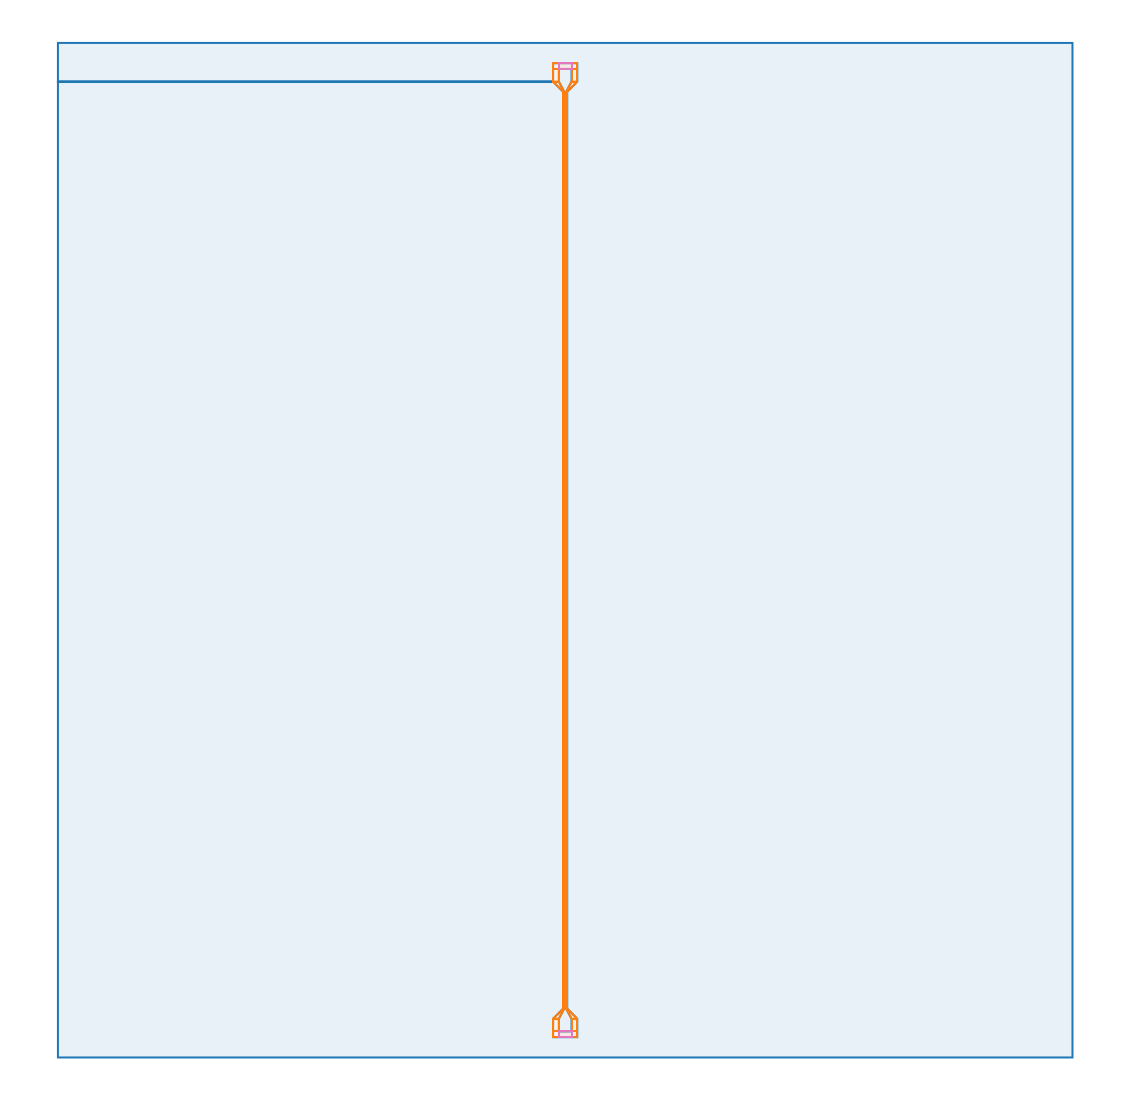

In [66]:
# Simulation rendering
mask = chip.render('mask', group=['Transmission'], sim=(0, 6))

fig = qd.plot(mask[0], figsize=(20,20), axis=False, grid=False)

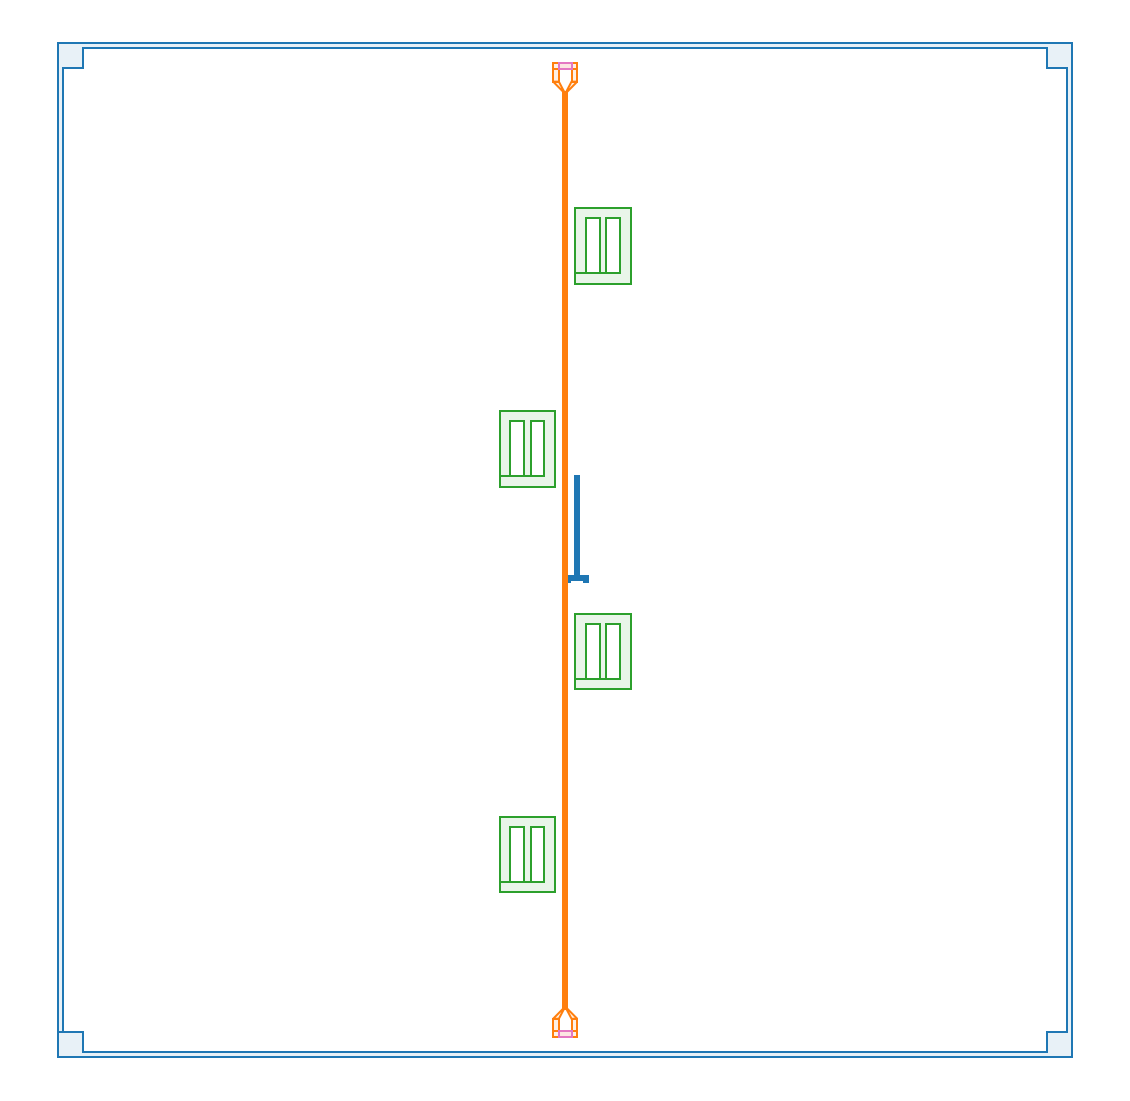

In [67]:
claw = qlib.Claw(
    cpw=cpw,
    base={
        'length': qbpads.get_params('pad1.x') + 2 * (cpw['width'] + cpw['gap']),
        'width': cpw['width']
    },
    fingers={'width': cpw['width'], 'length': 20},
    gap=cpw['gap'],
    cpw_length=1000
)
coupler = claw.attach(Q0, 'pad2_top', 'pad_cutout', offset = (0,-qbpads.get_params('pad1.y')), rotation = 180)
chip.add_component(coupler)

mask = chip.render('mask', draw_border=True)

fig = qd.plot(mask[0], figsize=(20,20), axis=False, grid=False)

In [68]:
# Flux trapping holes
# mask = chip.render('mask', draw_border=True, perforate=True)
# fig = qd.plot(mask[0], figsize=(20,20), axis=False, grid=False)

## Manhattan junction array

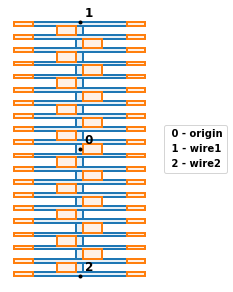

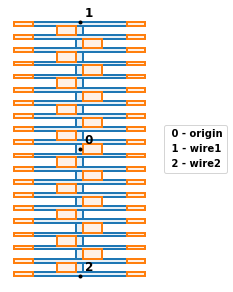

In [9]:
qj.JunctionArray.document()

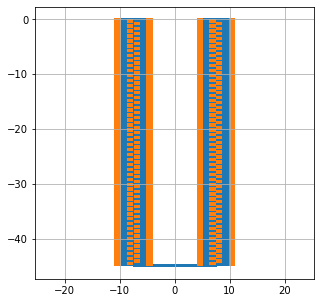

In [86]:
params = {'number':100, 
          'overlap': [5, 0.2], 
          'wire':[0.4, 0.25], 
          'undercut': 0.8,
         'undercut_after_JJ': 1.2}

n = params['number']
overlap = params['overlap']
wire = params['wire']
undercut = params['undercut']
undercut_after_JJ = params['undercut_after_JJ']
array_gap = overlap[0] + 10

array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
array1 = array.place((-array_gap/2, 0), node='wire1', rotation=0)
array2 = array.place((array_gap/2, 0), node='wire1', rotation=0)

lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, n*(wire[1]+overlap[1])))
fig = qd.plot([array1, array2, lead])

## Dolan bridge junction array
Drawing and simulating deposition of Dolan bridge junction array using 3 angles deposition


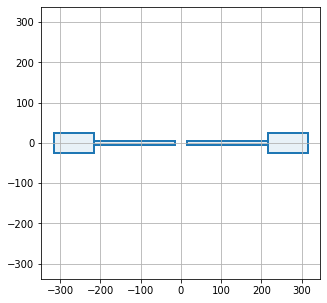

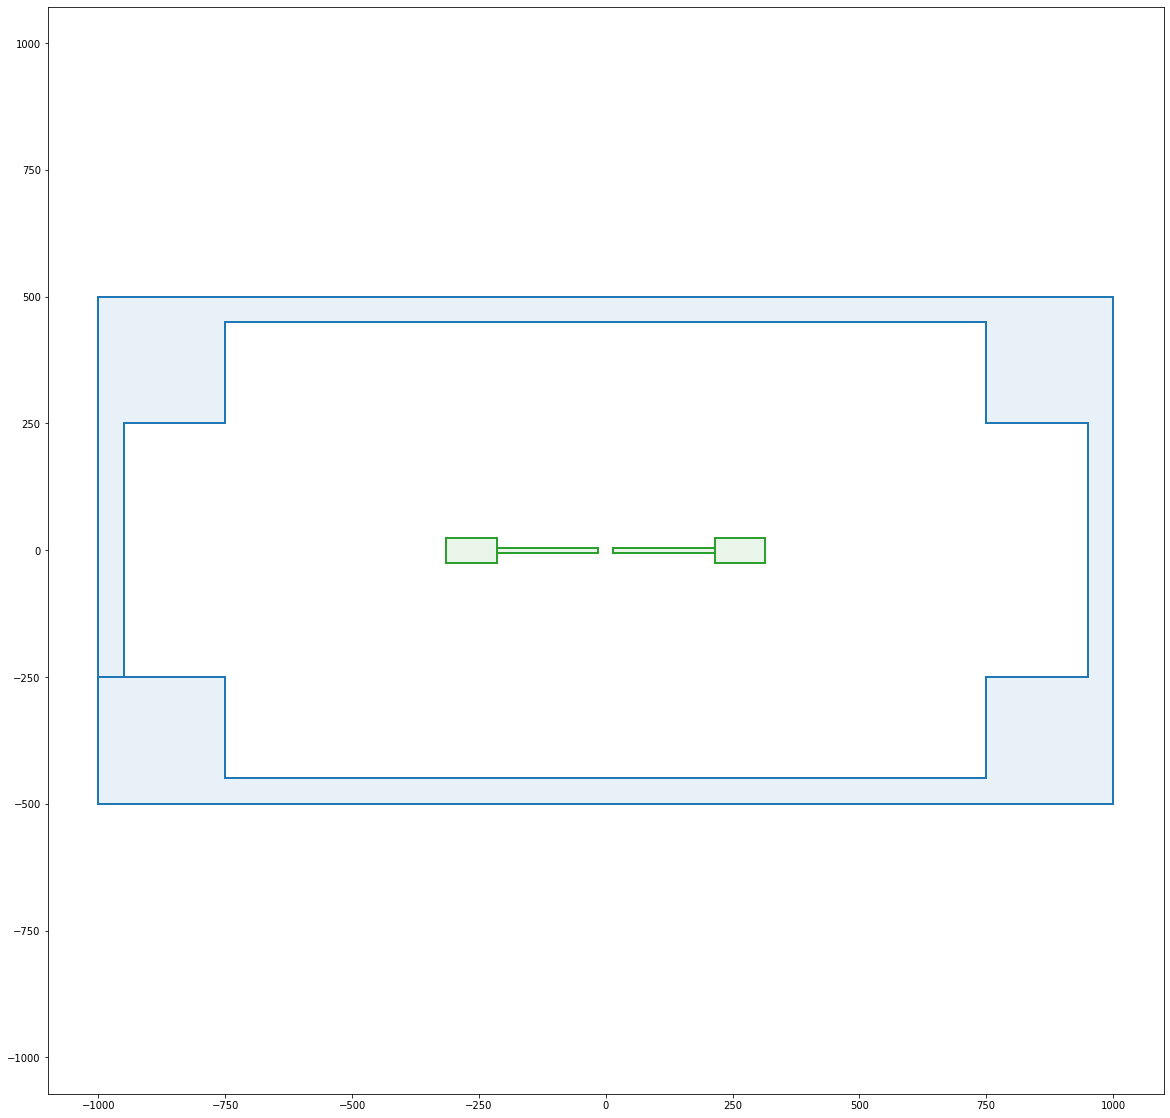

In [11]:
class dolanBridgeArray(components.Component):
    __draw__ = True
    
    def draw(self, pad, lead, gap):
        pad_x, pad_y = pad
        lead_x, lead_y = lead
        
        antenna = [
            shapes.Rectangle(pad_x, pad_y). translate((gap/2+lead_x+pad_x/2),0),
            shapes.Rectangle(pad_x, pad_y). translate(-(gap/2+lead_x+pad_x/2),0),
            shapes.Rectangle(lead_x, lead_y). translate(gap/2+lead_x/2,0),
            shapes.Rectangle(lead_x, lead_y). translate(-gap/2-lead_x/2,0)
        ]
        self.add(antenna)
        nodes = {
            'left': (gap/2,0)
        }
        return nodes
    
if __name__ == "__main__":
    lib = gdspy.GdsLibrary()
    chip = qd.Chip(size = (2000,1000))
    
    pad = (100,50)
    lead = (200, 10)
    gap = 30
    
    antenna = AntennaSymmetric(pad, lead, gap)
    
    params = {'number':100, 
          'overlap': [5, 0.2], 
          'wire':[0.4, 0.25], 
          'undercut': 0.8,
         'undercut_after_JJ': 1.2}

    lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset+n*(wire[1]+overlap[1])))
    chip.add_component(antenna, cid = 'antenna', layers = 2)
    mask = chip.render(name = 'fluxonium', draw_border = True)
    fig = qd.plot(mask[0], figsize=(20,20), axis=True, grid=False)

## Manhattan junction
Junctions are fabricated by depositing aluminum, so the traces defined are for deposition areas. The writing process uses a bilayer resist, with the top layer having high resolution and thin, while the bottom layer having high sensitivity for exposing undercuts. We will also define the overlay layer for undercut. Finally, there are bandages areas where the chip will be ion milled ensure galvanic connection.

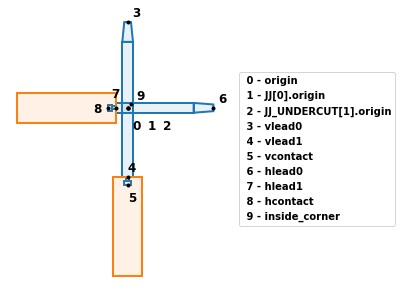

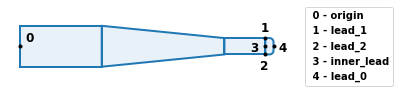

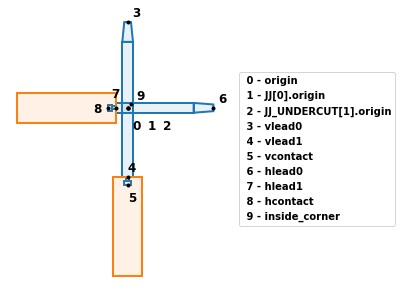

In [6]:


qj.JunctionLead.document()
qj.ManhattanJunction.document()

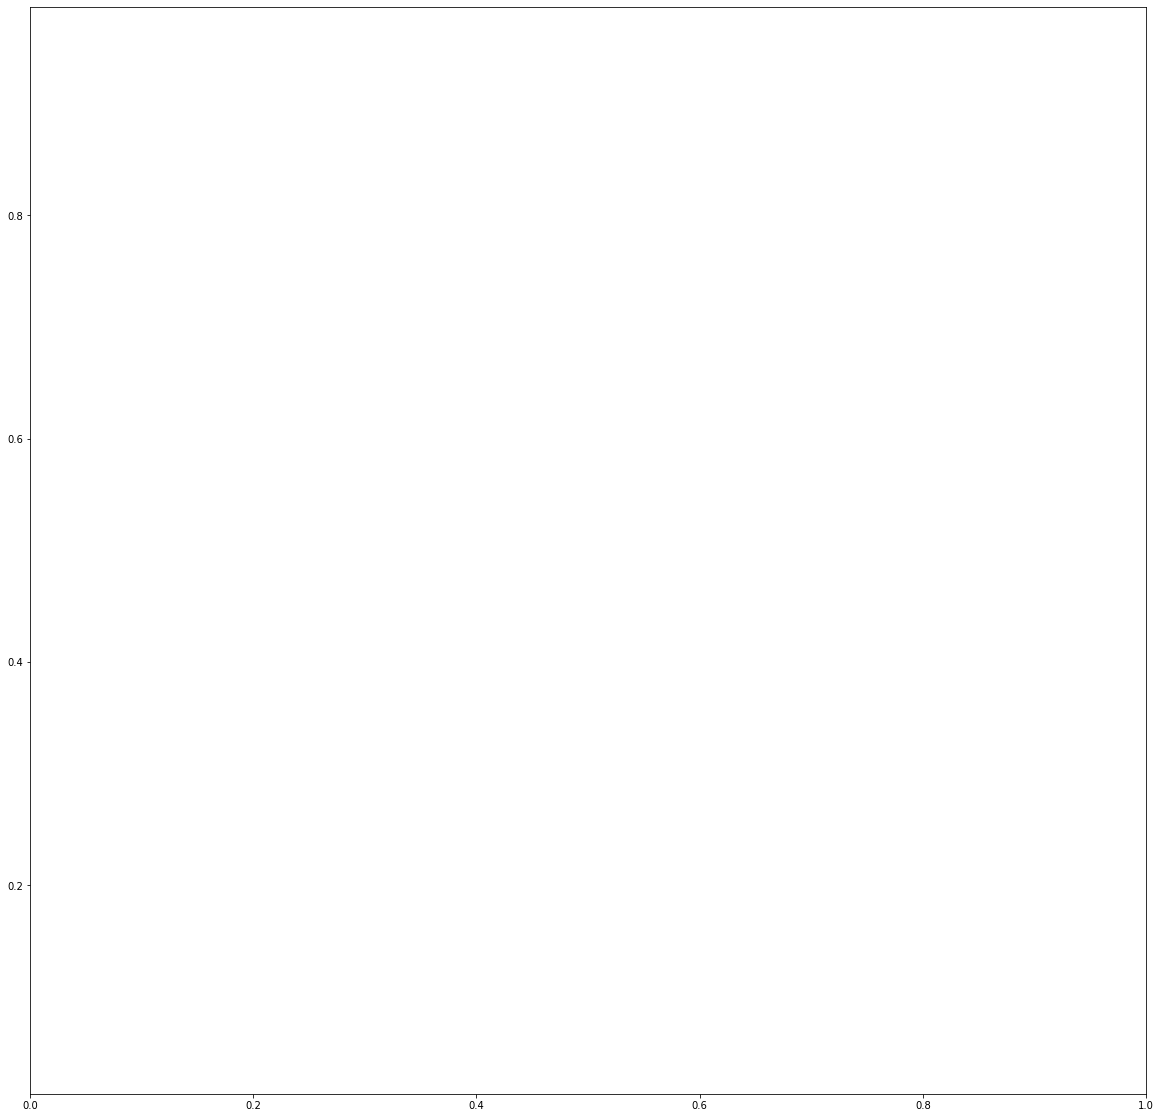

In [2]:
import gdspy
import numpy as np
import os
import ruamel.yaml as yaml

import qnldraw as qd
import qnldraw.junction as qj

from qnldraw import shapes, paths, components, Angle, Params

def make_junctions(params, junction_size, simulate_evap=True):
    # Make a deep copy of the parameters
    params = Params(params)
    # This will help us manage layers
    chip = qd.Chip()
    
    ### =============== Layout Parameters =============== ###
    pad_spacing = params['pad_spacing']
    lead_vertical_separation = np.sqrt(params['squid_loop_area'])
    lead_horizontal_separation = np.sqrt(params['squid_loop_area'])

    ur = 0.5 * np.array((lead_horizontal_separation, lead_vertical_separation))
    # Offset so inner edge lines up with SQUID loop area
    ur += 0.5 * params['wire.width']
    corners = {
        'upper_right': ur,
        'upper_left': ur * (-1, 1),
        'lower_left': ur * (-1, -1),
        'lower_right': ur * (1, -1)
    }

#     hdlayer = params['layers']['highdose']
#     ldlayer = params['layers']['lowdose']
    
    return chip.render('junction_mask', include_refs=True)

if __name__ == "__main__":
    lib = gdspy.GdsLibrary()
    lib.unit=1.0e-6
    lib.precision=1e-10
    ### ==================== Junction Areas ==================== ###
    jv = 0.25
    jh = 0.27
    params ={
    ### ==================== LAYOUT ==================== ###
    'pad_spacing': 65,
    'squid_loop_area': 500,  # microns^2
    'junction_position': 'lower_left',
    'junction_asymmetry': 1,
    'layers':
      {'highdose': 1,
      'lowdose': 2},
    ### ==================== JUNCTION LEADS ==================== ###
    'leads':
      {'outer':
        {'width': 5},
      'inner':
        {'width': 2,
        'length': 5}},
    'taper_length': 15,
    'fillet': 0.5,
    'pad_overlap': 5,

    ### ==================== BANDAGES ==================== ###
    'bandages':
      {'lx': 10,
      'ly': 15,
      'lead_overlap': 3,
      'layer': 3},
    ### ==================== JUNCTION WIRE ==================== ###
    'wire':
      {'width': 0.17,
      'taper_length': 0.5}

#     ### ==================== MANHATTAN STYLE JUNCTIONS ==================== ###
#     junction:
#       lengths:
#         length: 1.5
#         horizontal_extra: 0.2
#         vertical_extra: 1.75
#       contact:
#         narrow:
#           length: 0.1 # 0.150
#           width_multiplier: 0.3333333333333333
#         wide:
#           length: 0.1
#           width_multiplier: 0.6666666666666667
#       undercut:
#         layer: 2
#         multiplier: 0.6
#         length: 1.5
#         width_multiplier: 2    
        }
    mask = make_junctions(params, (jv, jh))
    fig = qd.plot(mask[0], figsize=(20,20), axis=True, grid=False)
    
    

## Multiqubit chip v6